# MicroB Prediction

__TRIN DATA FEATURES__


row_id,cfips,county,state,first_day_of_month
pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021
pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021
pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021
pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021
median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021

__FROM EXTERNAL__
Total!!Estimate!!Population 18 to 24 years!!Less than high school graduate!
Total!!Estimate!!Population 18 to 24 years!!High school graduate (includes equivalency)!
Total!!Estimate!!Population 18 to 24 years!!Some college or associate's degree!
Total!!Estimate!!Population 18 to 24 years!!Bachelor's degree or higher!

Total!!Estimate!!Population 25 years and over!!9th to 12th grade, no diploma!
Total!!Estimate!!Population 25 years and over!!High school graduate (includes equivalency)
Total!!Margin of Error!!Population 25 years and over!!Some college, no degree!2.png)
Total!!Estimate!!Population 25 years and over!!Associate's degree!
Total!!Estimate!!Population 25 years and over!!Bachelor's degree!
Total!!Estimate!!Population 25 years and over!!Graduate or professional degree!

__PREDICT__
microbusiness_density

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

# Data


In [258]:
df_train = pd.read_csv('/Users/joheunkang/microb/data/train.csv')
df_test = pd.read_csv('/Users/joheunkang/microb/data/test.csv')
df_census = pd.read_csv('/Users/joheunkang/microb/data/census_starter.csv')
df_s_a_edu21 = pd.read_csv('/Users/joheunkang/microb/data/external/state_a_2017_edu/ACSST1Y2017.S1501-Data.csv')


In [337]:
# Covid data 
# data souce : https://github.com/nytimes/covid-19-data
covid_20 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2020.csv")
covid_21 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2021.csv")
covid_22 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2022.csv")
covid_23 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2023.csv")
covid_recent = pd.read_csv("/Users/joheunkang/microb/data/us-counties-recent.csv")

# make class 

In [332]:
class Microb:
  def __init__(self,df,df_1):
    self.df = df  
    self.df1 = df_1

  def change_to_datetime(self):
    self.df['first_day_of_month'] = pd.to_datetime(self.df['first_day_of_month'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['first_day_of_month'].year)

  def create_m_month(self,row):
    return int(row['first_day_of_month'].month)

  def create_m_day(self,row):
    return int(row['first_day_of_month'].day)
  
  def get_m_year(self):
    self.df['m_year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['m_month']= self.df.apply(lambda row:self.create_m_month(row),axis = 1)
    self.df['m_day']= self.df.apply(lambda row:self.create_m_day(row),axis = 1)
      
  def get_first_day_of_prev_month(self):
    self.df['first_day_of_p1_m'] = self.df['first_day_of_month'] - pd.DateOffset(months=1)

  def get_first_day_of_prev_year(self):
    self.df['first_day_of_p1_y'] = self.df['first_day_of_month'] - pd.DateOffset(months=12)
  
  def collect_p1_kind(self,row,kind):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'pct_{kind}_{prev_year}']


  def merge(self):
    self.df = pd.merge(self.df, self.df1, on = 'cfips')
    
  def collect_p1_median_hh(self,row):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'median_hh_inc_{prev_year}']

    
  def get_p1_y_data(self):
    self.df['p1_y_bb'] = self.df.apply(lambda row: self.collect_p1_kind(row,'bb'),axis = 1)
    self.df['p1_y_college'] = self.df.apply(lambda row: self.collect_p1_kind(row,'college'),axis = 1)
    self.df['p1_y_foreign_born'] = self.df.apply(lambda row: self.collect_p1_kind(row,'foreign_born'),axis = 1)
    self.df['p1_y_it_workers'] = self.df.apply(lambda row: self.collect_p1_kind(row,'it_workers'),axis = 1)
    self.df['p1_y_median_hh_inc'] = self.df.apply(lambda row: self.collect_p1_median_hh(row),axis = 1)
    
  def create_p1_m_microb_density(self,row):
    is_exist =self.df[(self.df['cfips']==row['cfips'])&(self.df['first_day_of_month']==row['first_day_of_p1_m'])]
  
    if is_exist: 
      return is_exist['microbusiness_density']
    else: 
      return None
  def get_p1_m_microb_density(self):
    df["p1_m_microb_density"] = self.df.apply(lambda row: self.create_p1_m_microb_density(row),axis = 1)

  def get_df(self):
    return self.df 

In [333]:
d_train= Microb(df_train,df_census)
d_train.change_to_datetime()
d_train.get_m_year()
d_train.get_first_day_of_prev_month()
d_train.get_first_day_of_prev_year()
d_train.merge()
d_train.get_p1_y_data()
# d_train.get_p1_m_microb_density()
d = d_train.get_df()
d.head()

#d_train.get_first_day_of_prev_year()
#d = d_train.get_df()

# d_train.get_first_day_of_prev_year()
# d_train.get_p1_y_data()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0


In [334]:
print(len(d))

122265


In [335]:
temp = d[['cfips','first_day_of_month','microbusiness_density']]
temp = temp.rename(columns={"first_day_of_month":"first_day_of_p1_m"})
d= d.merge(temp, how='left', on=['cfips','first_day_of_p1_m'])
d= d.rename(columns={"microbusiness_density_y":"p1_m_mcrob_density"})

In [336]:
d.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.007682
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.884870
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.055843
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.993233


p6_m_mcrob_density may needed : most buisness takes 6 month to open

# Covid data

In [412]:
covid_20.head()
df_covid = pd.concat([covid_20,covid_21,covid_22,covid_23,covid_recent],axis = 0)
print(len(df_covid))
df_covid.head()

3515398


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [413]:
class Covid:
  def __init__(self,df):
    self.df = df
  def change_to_datetime(self):
    self.df['date'] = pd.to_datetime(self.df['date'], format='%Y-%m-%d')
    
  def create_m_year(self,row):
    return  int(row['date'].year)

  def create_m_month(self,row):
    return int(row['date'].month)
  
  def get_y_m(self):
    self.df['year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['month']= self.df.apply(lambda row: self.create_m_month(row),axis = 1)

  # collect groupby monthly mean, median for  
  def collect_county_m_case_mean(self):
    return self.df.groupby(['county','state','year','month'])[['cases']].mean().rename(columns = {'cases':'county_m_case_mean'})

  def collect_county_m_case_median(self):
    return self.df.groupby(['county','state','year','month'])[['cases']].median().rename(columns= {'cases':'county_m_case_median'})

  def collect_county_m_death_mean(self):
    return self.df.groupby(['county','state','year','month'])[['deaths']].mean().rename(columns = {'deaths':'county_m_deaths_mean'})

  def collect_county_m_death_median(self):
    return self.df.groupby(['county','state','year','month'])[['deaths']].median().rename(columns= {'deaths':'county_m_deaths_median'})
  
  def merge_case_death(self):
    self.df = pd.merge(self.df,self.collect_county_m_case_mean(), on = ['county','state','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_case_median(), on =['county','state','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_mean(), on = ['county','state','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_median(), on =['county','state','year','month'])
  
  def drop_cols(self):
    self.df = self.df.drop(['date', 'cases','deaths'], axis=1)
    self.df = self.df.drop_duplicates()
    
  def get_data(self):
    return self.df 
  

  

In [414]:
CovidData= Covid(df_covid)
CovidData.change_to_datetime()
CovidData.get_y_m()
CovidData.merge_case_death()
CovidData.drop_cols()
df_covid1 = CovidData.get_data()

In [415]:
df_covid1.head()

,county,state,fips,year,month,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061.0,2020,1,1.00,1.0,0.0,0.0
11,Cook,Illinois,17031.0,2020,1,1.25,1.0,0.0,0.0
19,Orange,California,6059.0,2020,1,1.00,1.0,0.0,0.0
26,Maricopa,Arizona,4013.0,2020,1,1.00,1.0,0.0,0.0
32,Los Angeles,California,6037.0,2020,1,1.00,1.0,0.0,0.0


In [416]:
print(len(df_covid1))

115406


# Create Test data for 9/1/2022 and 10/1/2022 

# Clean train data colum names

In [6]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [7]:
print(len(df_train))

122265


In [8]:
def create_m_year(row):
  return int(row['first_day_of_month'].split('-')[0])

def create_m_month(row):
  return int(row['first_day_of_month'].split('-')[1])

def create_m_day(row):
  return int(row['first_day_of_month'].split('-')[2])

In [9]:
df_train['m_year']= df_train.apply(lambda row:create_m_year(row),axis = 1)
df_train['m_month']= df_train.apply(lambda row:create_m_month(row),axis = 1)
df_train['m_day']= df_train.apply(lambda row:create_m_day(row),axis = 1)

In [10]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1


# combine helper data and train data 
combine with previous year data 


In [11]:
def get_prev_year(row): 
  return row['m_year']-1


In [13]:
df_train['m_prev1_year'] = df_train.apply(lambda row: get_prev_year(row),axis = 1)


In [14]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,m_prev1_year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,2018
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,2018
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,2018
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,2018
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,2018


# Join df_train and df_census on cfips 
- then, create prev1_college, prev1 pct_bb,,, for each column kind  extra and remove 2017,2018,,,2020


In [27]:
df_tc = pd.merge(df_train,df_census, on = 'cfips')
print(df_tc.columns)

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'm_year', 'm_month', 'm_day',
       'm_prev1_year', 'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019',
       'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


In [28]:
def collect_p1_kind(row,kind):
  collect_year= row['m_year']
  prev_year = collect_year -1
  if prev_year ==2017:
    return None 
  else: 
    return row[f'pct_{kind}_{prev_year}']

def collect_p1_median_hh(row):
  collect_year= row['m_year']
  prev_year = collect_year -1
  if prev_year ==2017:
    return None 
  else: 
    return row[f'median_hh_inc_{prev_year}']
  c
df_tc['p1_bb'] = df_tc.apply(lambda row: collect_p1_kind(row,'bb'),axis = 1)
df_tc['p1_college'] = df_tc.apply(lambda row: collect_p1_kind(row,'college'),axis = 1)
df_tc['p1_foreign_born'] = df_tc.apply(lambda row: collect_p1_kind(row,'foreign_born'),axis = 1)
df_tc['p1_it_workers'] = df_tc.apply(lambda row: collect_p1_kind(row,'it_workers'),axis = 1)
df_tc['p1_median_hh_inc'] = df_tc.apply(lambda row: collect_p1_median_hh(row),axis = 1)



In [95]:
df_tc.head(5)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_bb,p1_college,p1_foreign_born,p1_it_workers,p1_median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0


In [250]:
# change first_day_of_month as datetime 
# get first_day_of_prev_month as columm
# get first_day_of_prev_year as column

# get prev microb for prev month
# get prev microb for prev year 



row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
m_year                     int64
m_month                    int64
m_day                      int64
m_prev1_year               int64
pct_bb_2017              float64
pct_bb_2018              float64
pct_bb_2019              float64
pct_bb_2020              float64
pct_bb_2021              float64
pct_college_2017         float64
pct_college_2018         float64
pct_college_2019         float64
pct_college_2020         float64
pct_college_2021         float64
pct_foreign_born_2017    float64
pct_foreign_born_2018    float64
pct_foreign_born_2019    float64
pct_foreign_born_2020    float64
pct_foreign_born_2021    float64
pct_it_workers_2017      float64
pct_it_workers_2018      float64
pct_it_workers_2019      float64
pct_it_workers_2020      float64
pct_it_wor

In [ ]:
def get_first_day_of_prev_month():
  pass 

def get_first_day_of_prev_year():
  pass 



In [242]:
def plot_y_m_microb(df,year:int,state:str,county:str):
  df = df[(df['state'] == state)&(df['county'] == county)]
  df = df[df['m_year']== year][['m_month','microbusiness_density']]
  print('len',len(df))
  plt.plot(df['m_month'],df['microbusiness_density'])
  
def plot_by_st_cnty(df,state,year):   
  df_year_state = df[(df['state'] == state)&(df['m_year'] == year)]
  ls_cnty = df_year_state['county'].unique()

  for county in ls_cnty: 
    #print('county name: ',county)
    df_county = df_year_state[df['county']==county]
    df_county = df_county[['state','m_month','microbusiness_density']]
    month  = list(df_county['m_month'])
    mb = list(df_county['microbusiness_density'])
    plt.scatter(month,mb,label = county)
    plt.legend()

def get_all_cnty(df,state):
  return list(df[df['state']==state]['county'].unique())

def get_df_st_cnty(df,s,c):
  ls_year = [2019,2020,2021,2022]
  df = df[(df['state']==s)&(df['county']==c)]
  for y in ls_year:
    print('yera',y)
    df_tmp = df[df['m_year']==y]
    ls_fdm = list(df_tmp['m_month'])
    ls_mcb = list(df_tmp['microbusiness_density'])
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(5)
    plt.scatter(ls_fdm,ls_mcb)


[]
yera 2019
yera 2020
yera 2021
yera 2022


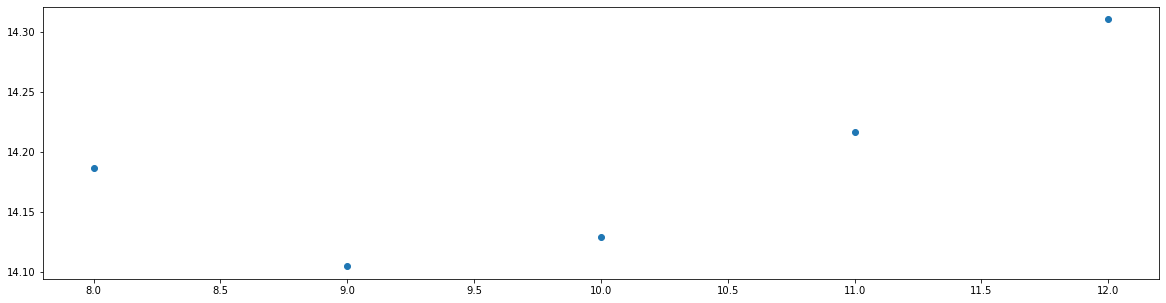

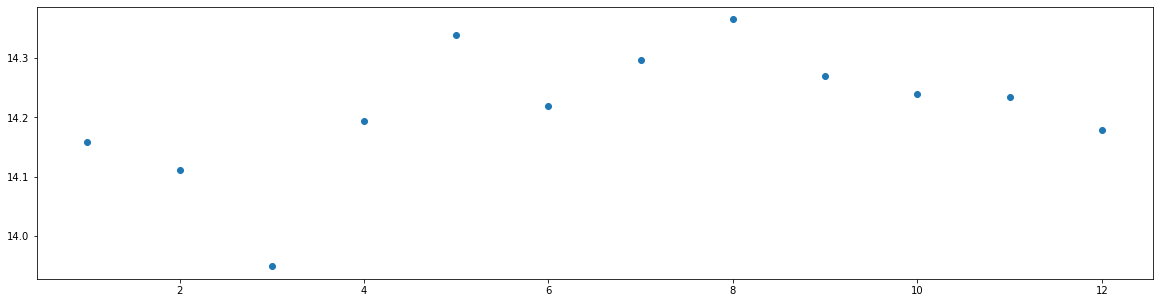

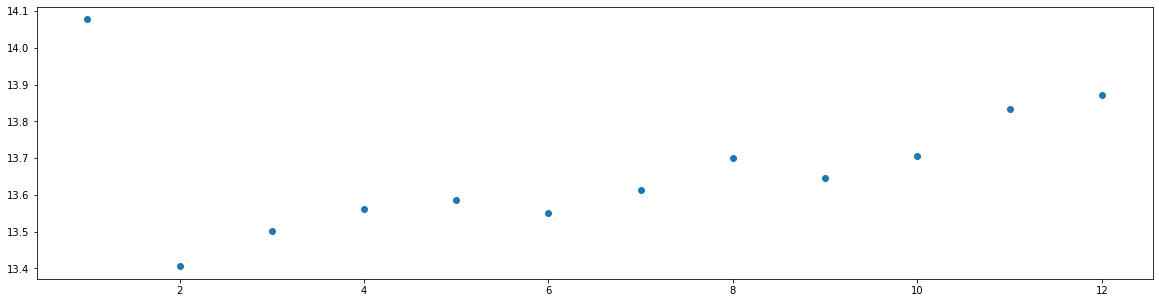

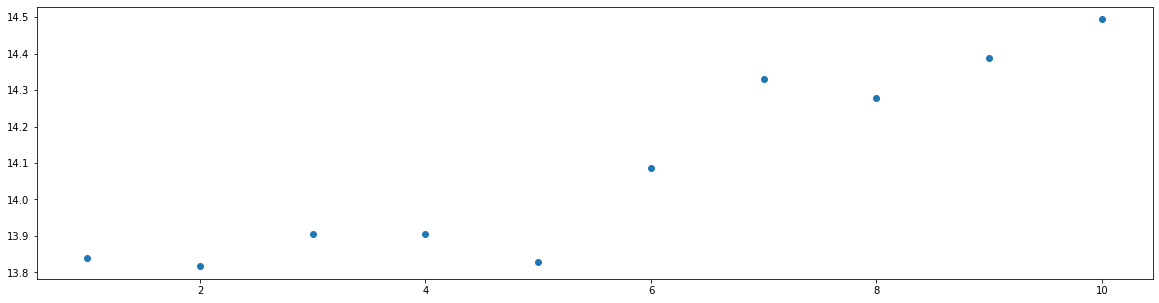

In [247]:
# county per state
ls_cnty = get_all_cnty(df_tc,'Los Angeles')
print(ls_cnty)
# yearly trend (usually higher in late year)
get_df_st_cnty(df_tc,'California','San Diego County')

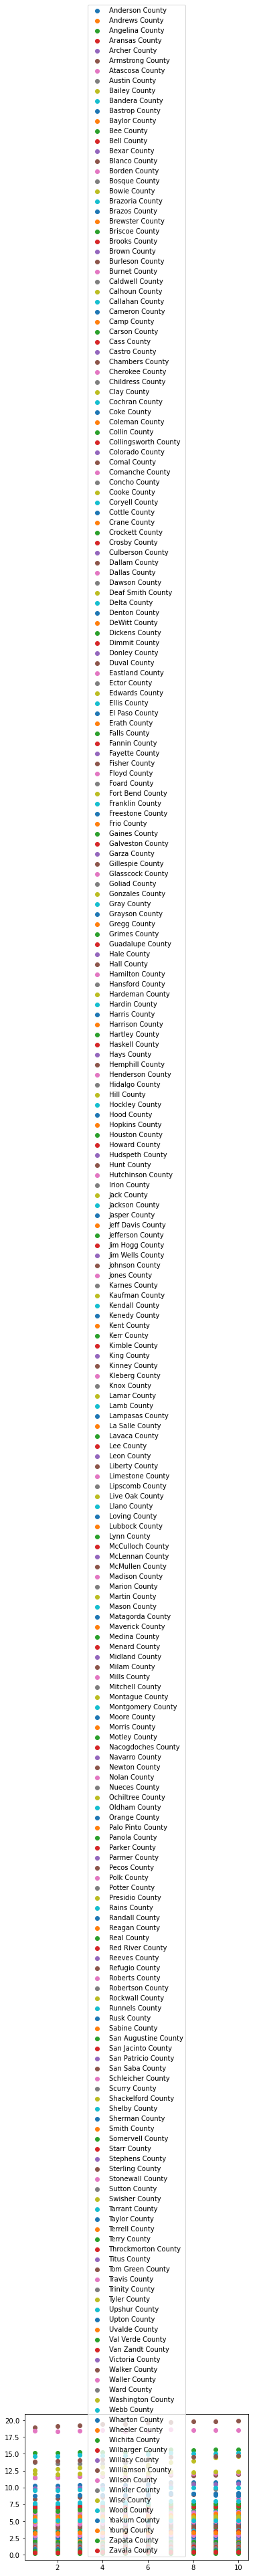

In [152]:
# Is microbusiness density yearly trend same per month? 
# plot_y_m_microb(df_tc,2022,'Texas','Zavala County')
# plot_y_m_microb(df_tc,2021,'Wyoming','Washakie County')
# plot_y_m_microb(df_tc,2020,'Wyoming','Washakie County')
# plot_y_m_microb(df_tc,2019,'Wyoming','Washakie County')
plot_by_st_cnty(df_tc,'Texas',2022)



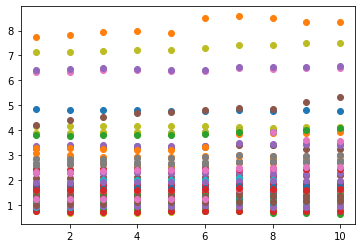

In [144]:
plot_by_st_cnty(df_tc,'Alabama',2022)

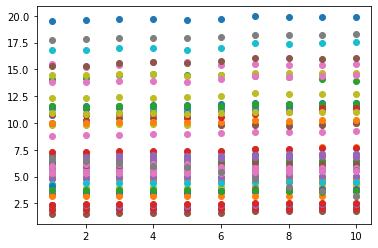

In [145]:
plot_by_st_cnty(df_tc,'California',2022)

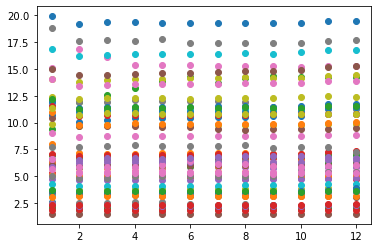

In [146]:
plot_by_st_cnty(df_tc,'California',2021)

In [40]:
df_alabama_2022

,m_month,microbusiness_density
29,1,3.296781
30,2,3.334431
31,3,3.336785
32,4,3.372082
33,5,3.313253
...,...,...
2608,6,1.234502
2609,7,2.463707
2610,8,3.947229
2611,9,3.597542


In [ ]:
plt.plot(df_)

# Clean helper data colum names 

In [32]:
print(len(df_census))

3142


In [15]:
df_census.head(5) # pct_collge_xxxx: esstimate percentage for bachelor's degree 

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [30]:
# how to combine yearly and monthly data well? 

# State_a_clean column names (education)